In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
dataset_name = 'inhouse'

### raw rna

In [3]:
# GSM4476364 raw inhouse
rna = pd.read_csv('/home/zqzhao/workplace/Multi_omics_unet/dataset/INhouse/data/GSM4476364_RNA_raw.csv.gz', header=0, index_col=0)

In [4]:
ground_truth = pd.read_csv("/home/zqzhao/workplace/Multi_omics_unet/dataset/INhouse/data/truth_InHouse.csv")
y = ground_truth['trueType_y'].values.astype(str)

In [5]:
rna_adata = sc.AnnData(X=rna.values.T)
rna_adata.obs_names = rna.columns
rna_adata.var_names = rna.index
rna_adata.obs['cell_type'] = y
rna_adata.obs['cell_type'] = rna_adata.obs['cell_type'].astype('category')
rna_adata

AnnData object with n_obs × n_vars = 1182 × 33538
    obs: 'cell_type'

### hidden

In [6]:
hidden = np.load(f'/home/zqzhao/workplace/OSMVC-master/latent/{dataset_name}_glb_vector.npy')
hidden.shape

(1182, 1000)

In [7]:
pred_y = np.load(f'/home/zqzhao/workplace/OSMVC-master/latent/{dataset_name}_target_pred.npy')
pred_y.max(), pred_y.min()

(5, 0)

In [8]:
hidden = sc.AnnData(X=hidden)
hidden.obs['label'] = y.astype(str)
sc.tl.pca(hidden, svd_solver='arpack')
hidden.obs['label'] = hidden.obs['label'].astype('category')
hidden.obsm['X_pca'].shape

(1182, 50)

In [13]:
# np.char.replace(ground_truth['Barcode'].values.astype(str), '-', '.') == rna.obs.index.values

In [9]:
import matplotlib.pyplot as plt

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'scECDA'}, xlabel='UMAP1', ylabel='UMAP2'>

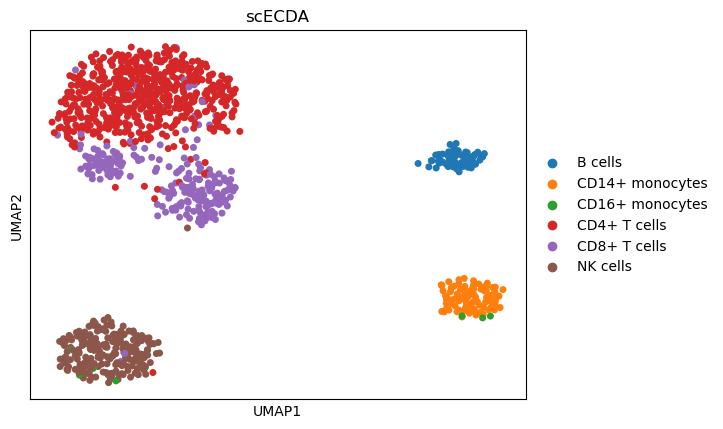

In [10]:
sc.pp.neighbors(hidden, use_rep="X_pca")
sc.tl.umap(hidden)
sc.pl.umap(hidden, color='label', title='scECDA', show=False) #palette='Set1'
# plt.savefig(f'/home/zqzhao/workplace/OSMVC-master/plot/{dataset_name}_umap.svg', bbox_inches='tight')

In [11]:
adata = rna_adata.copy()
adata.obs['pred'] = pred_y.astype('str')
adata.obs['pred'] = adata.obs['pred'].astype('category')
adata.var_names_make_unique()

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [28]:
# del adata.uns

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


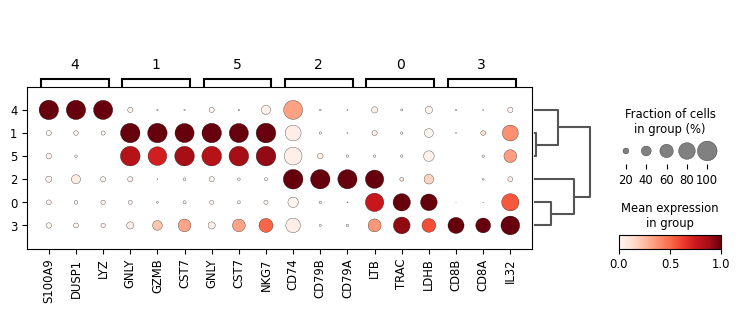

In [12]:
sc.tl.rank_genes_groups(adata, 'pred', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, groupby='pred', standard_scale='var', show=False)
plt.savefig(f'/home/zqzhao/workplace/OSMVC-master/plot/rst/{dataset_name}_pred_dot.svg', bbox_inches='tight')

In [13]:
hidden

AnnData object with n_obs × n_vars = 1182 × 1000
    obs: 'label'
    uns: 'pca', 'neighbors', 'umap', 'label_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/zqzhao/software/anaconda3/envs/pytorch1.10/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


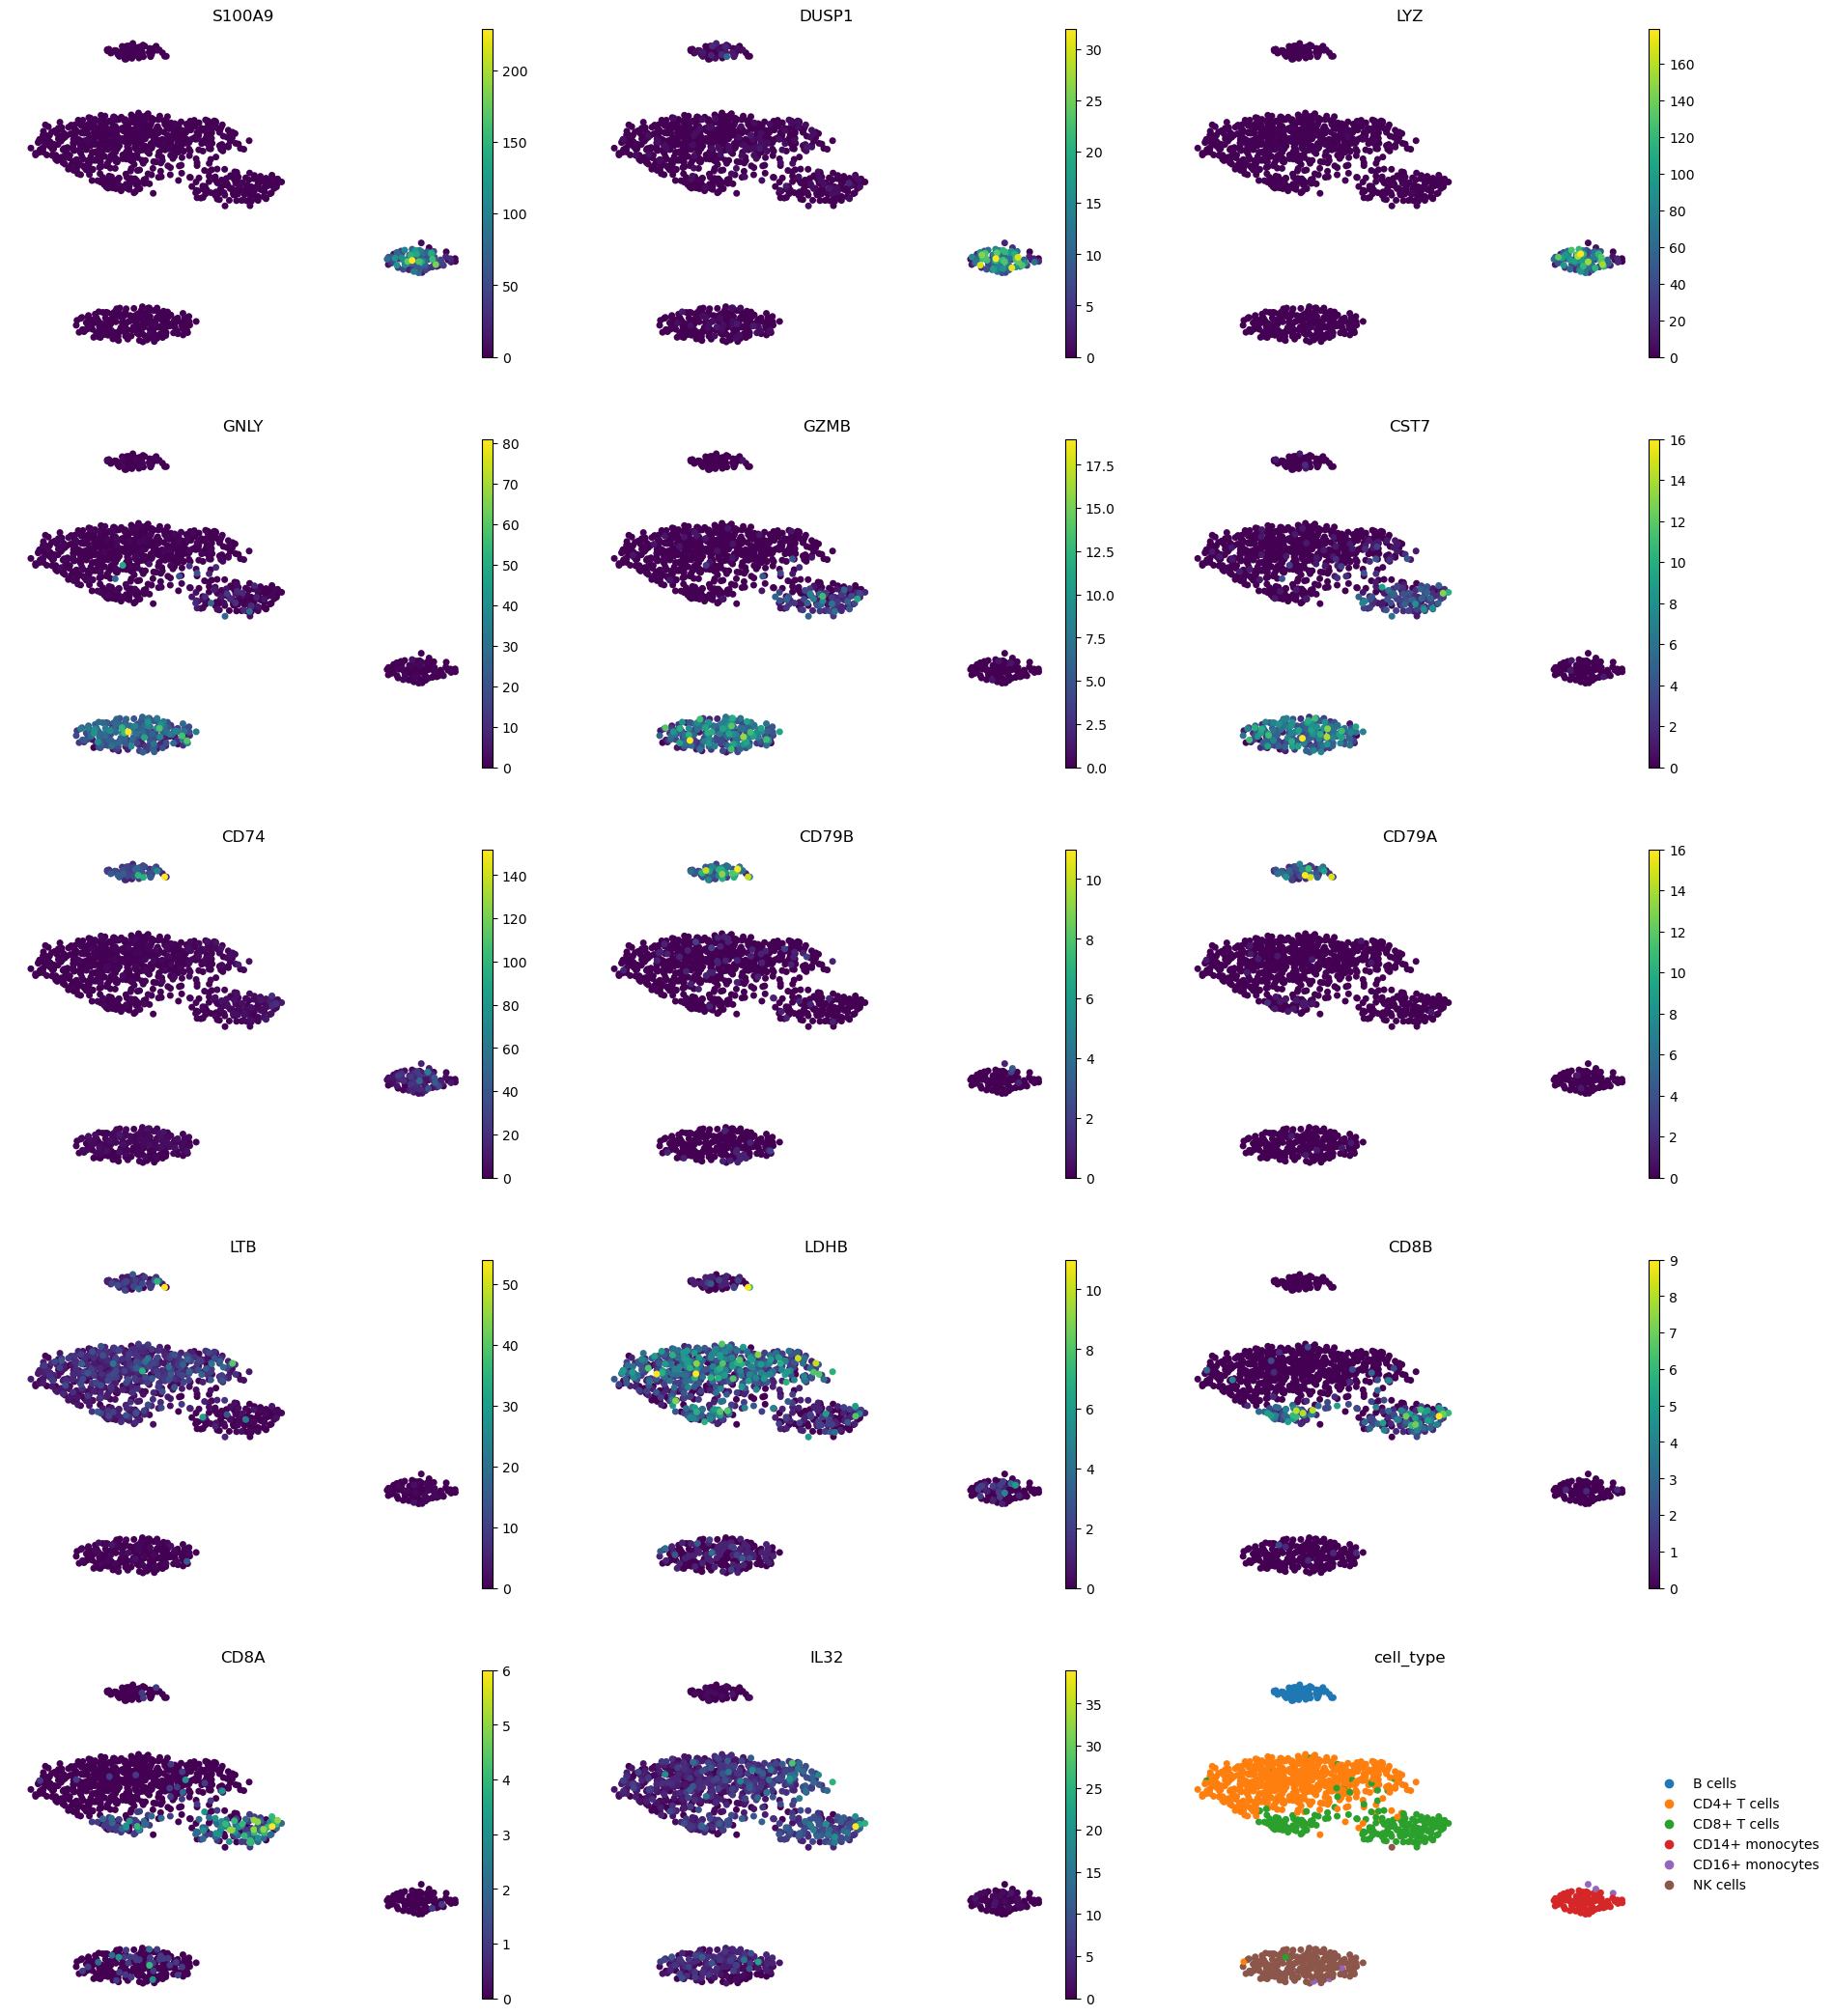

In [32]:
sc.pl.umap(adata, color=["S100A9", "DUSP1", "LYZ", "GNLY", "GZMB", "CST7", "CD74", "CD79B", "CD79A", "LTB", "LDHB", "CD8B", "CD8A", "IL32", "cell_type"], ncols=3, frameon=False, show=False)
plt.savefig(f'/home/zqzhao/workplace/OSMVC-master/plot/rst/{dataset_name}_UMI.svg', bbox_inches='tight')

In [14]:
adata

AnnData object with n_obs × n_vars = 1182 × 33538
    obs: 'cell_type', 'pred'
    uns: 'rank_genes_groups', 'dendrogram_pred'
    obsm: 'X_pca'

In [15]:
adata.uns['rank_genes_groups']['names'][0]

('LTB', 'GNLY', 'CD74', 'CD8B', 'S100A9', 'GNLY')

In [16]:
adata.uns['rank_genes_groups']['names'].shape

(33538,)

In [17]:
# 获取所有唯一的细胞类型
y_p = adata.obs['pred'].cat.categories

# 初始化存储结果的列表
ls = []

# 遍历每个细胞类型
for ct in y_p:
    # 获取当前细胞类型在 `names` 中的索引（假设细胞类型的顺序与 `names` 的列顺序一致）
    # 如果 `names` 的列顺序与 `cell_types` 不一致，需要进一步处理
    idx = np.where(y_p == ct)[0][0]
    # print(idx)
    # 提取当前细胞类型排名前 10 的基因
    top_10_genes = list(adata.uns['rank_genes_groups']['names'][idx])[:10]
    
    # 将基因添加到列表中
    ls.extend(top_10_genes)

# 打印结果
print(ls)

['LTB', 'GNLY', 'CD74', 'CD8B', 'S100A9', 'GNLY', 'TRAC', 'GZMB', 'CD79B', 'CD8A', 'DUSP1', 'CST7', 'LDHB', 'CST7', 'CD79A', 'IL32', 'LYZ', 'NKG7', 'RPLP2', 'NKG7', 'HLA-DRA', 'CD3D', 'S100A8', 'PRF1', 'RPS25', 'FGFBP2', 'IGHM', 'CCL5', 'NFKBIA', 'GZMA', 'RPL32', 'PRF1', 'HLA-DRB5', 'GZMM', 'AC020656.1', 'CD7']


In [48]:
adata.uns['rank_genes_groups']['names']#['params']


rec.array([('LTB', 'GNLY', 'CD74', 'CD8B', 'S100A9', 'GNLY'),
           ('TRAC', 'GZMB', 'CD79B', 'CD8A', 'DUSP1', 'CST7'),
           ('LDHB', 'CST7', 'CD79A', 'IL32', 'LYZ', 'NKG7'), ...,
           ('MT-CO1', 'TRAC', 'HCST', 'NPC2', 'RPS29', 'RPLP2'),
           ('NKG7', 'RPL39', 'CD3E', 'SELL', 'IL32', 'LTB'),
           ('CYBA', 'LTB', 'IL32', 'TYROBP', 'MALAT1', 'RPL39')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O')])

In [18]:
deg_top_20 = list(set(pd.DataFrame(adata.uns["rank_genes_groups"]["names"])[:20].values.reshape(-1)))

### Go

In [19]:
import gseapy as gp

In [20]:
gene_ls = ["S100A9", "DUSP1", "LYZ", "GNLY", "GZMB", "CST7", "CD74", "CD79B", "CD79A", "LTB", "LDHB", "CD8B", "CD8A", "IL32",]

In [21]:
enr_kegg = gp.enrichr(
    gene_list=deg_top_20, #gene_ls,
    gene_sets='KEGG_2021_Human',
    organism='Human',
    outdir='/home/zqzhao/workplace/OSMVC-master/plot/rst',
    cutoff=0.05
)

In [22]:
enr_kegg.results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Graft-versus-host disease,13/42,1.844042e-20,2.194410e-18,0,0,98.959387,4496.688993,HLA-DRB5;PRF1;HLA-B;GZMB;HLA-C;HLA-A;IL1B;HLA-...
1,KEGG_2021_Human,Antigen processing and presentation,15/78,5.506382e-20,3.276297e-18,0,0,53.663420,2379.746970,CD74;HLA-DRB5;HLA-B;HLA-C;HLA-A;CTSS;CD8B;CD8A...
2,KEGG_2021_Human,Type I diabetes mellitus,12/43,2.413173e-18,7.403800e-17,0,0,84.506203,3428.043930,HLA-DRB5;IL1B;PRF1;HLA-B;HLA-DPB1;GZMB;HLA-C;H...
3,KEGG_2021_Human,Hematopoietic cell lineage,15/99,2.488672e-18,7.403800e-17,0,0,40.204951,1629.698948,HLA-DRB5;CD3G;CD3E;CD3D;CD8B;CD8A;IL1B;CD7;HLA...
4,KEGG_2021_Human,Allograft rejection,11/38,4.181784e-17,9.952646e-16,0,0,87.991143,3318.428348,HLA-DRB5;PRF1;HLA-B;HLA-DPB1;GZMB;HLA-C;HLA-DR...


In [23]:
msig = gp.Msigdb()
gmt = msig.get_gmt(category='h.all', dbver="2025.1.Hs")

In [24]:
gmt

{'HALLMARK_ADIPOGENESIS': ['ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

In [38]:
msig.list_dbver()

,Name,Last modified
0,6.0,2018-12-17 16:29
1,6.1,2018-12-17 16:29
2,6.2,2018-12-17 16:29
3,7.0,2020-01-27 04:43
4,7.1,2020-03-30 16:55
5,7.2,2020-09-18 23:33
6,7.3,2021-03-22 15:09
7,7.4,2021-04-02 14:38
8,7.5.1,2023-03-09 19:38
9,7.5,2022-01-13 01:00


In [25]:
enr_h = gp.enrichr(
    gene_list=deg_top_20,#gene_ls,
    gene_sets=gmt,
    organism='Human',
    outdir='/home/zqzhao/workplace/OSMVC-master/plot/rst',
    cutoff=0.05
)

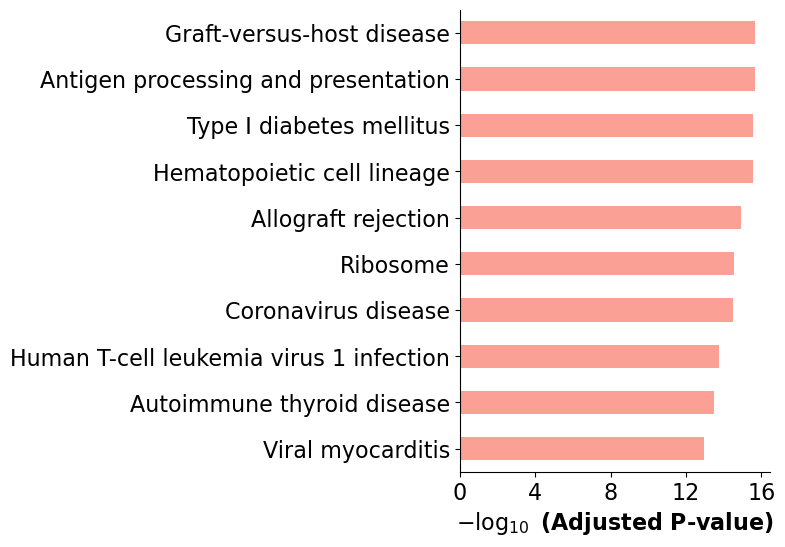

In [26]:
from gseapy.plot import barplot, dotplot
barplot(enr_kegg.res2d)
plt.savefig(f'/home/zqzhao/workplace/OSMVC-master/plot/rst/{dataset_name}_ehr.svg', bbox_inches='tight', dpi=600)

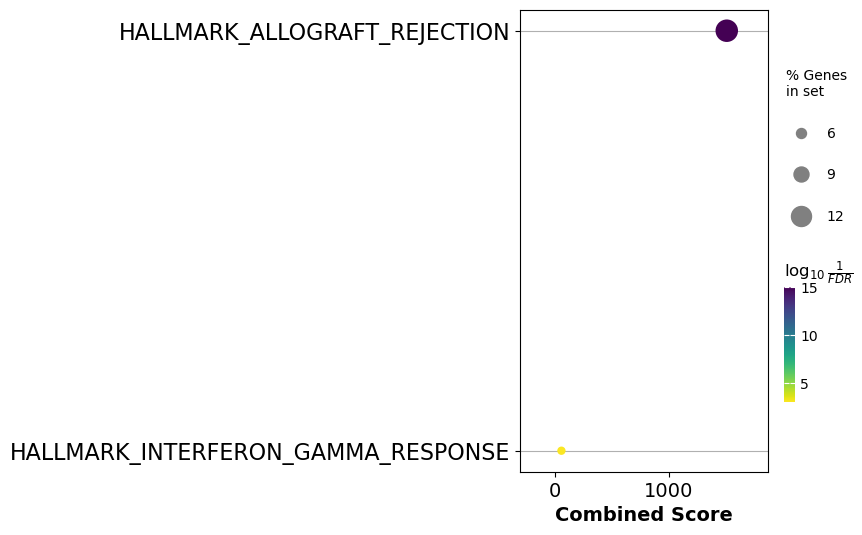

In [27]:
dotplot(enr_h.res2d,size =20)
plt.savefig(f'/home/zqzhao/workplace/OSMVC-master/plot/rst/{dataset_name}_score.svg', bbox_inches='tight', dpi=600)